------

### Requirements
```python
# numpy==1.23.4
# matplotlib
torch
# scikit-image
# odl==0.7.0
# dival
# wget # for downloading the test data
pillow # Image utils
```

In [41]:
# !pip install pillow
# !pip install torch
# !pip install numpy
# !pip install matplotlib
# !pip install tqdm
# !pip install wandb

In [42]:
import os

# NOTE: Importing torch the first time will always take a long time!
import torch
import torch.nn as nn
from torch.utils.data import WeightedRandomSampler
import torch.nn.functional as F
from torch.utils.data import Dataset

from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import datetime

from PIL import Image

# Optional
from tqdm import tqdm # progress bar

import wandb # Optional, for logging



In [43]:
!which python
print(f"Torch version: {torch.__version__}")
print(f"Path: {os.getcwd()}")

/mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/venv-2/bin/python


Torch version: 2.3.0+cu121
Path: /mnt/c/Users/t/Documents/GIT/LearningRegularizationParameterMaps/scripts/dyn_img_static


In [44]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [45]:
ENABLING_TESTS = True
# ENABLING_TESTS = False   # Disable tests for less output

In [46]:
# LOGGING_WITH_WANDB = True # NOTE: Only enable this if you have wandb installed and an account
LOGGING_WITH_WANDB = False  

### Use GPU

In [47]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"Using {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"Using {torch.backends.mps.get_device_name(0)} with MPS")
else:
    DEVICE = torch.device("cpu")
    print("Using CPU")

torch.set_default_device(DEVICE)

Using NVIDIA GeForce RTX 4090


------

### Import the image and transform the data

#### Download the data

In [48]:
# # REMEMBER TO COMMENT THIS OUT IF THE DATA HAS BEEN DOWNLOADED!
# !wget https://competitions.codalab.org/my/datasets/download/a26784fe-cf33-48c2-b61f-94b299dbc0f2
# !unzip "a26784fe-cf33-48c2-b61f-94b299dbc0f2" -d .

In [49]:
DATA_PATH = "./SIDD_Small_sRGB_Only/Data"

#### Take a single image

In [50]:
def get_npy_file(sample_path: str, scale_factor: float) -> np.ndarray:			
    scale_factor_str = str(scale_factor).replace('.','_')
    xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
    xf = torch.tensor(xf, dtype=torch.float)
    xf = xf.unsqueeze(0) / 255
    return xf

In [51]:
# CODE TO GET AN IMAGE FROM LOCAL FILE SYSTEM
# TODO: CHANGE THIS TO YOUR PATH
# NOTE: Windows uses \\ instead of /
def load_images(ids: list, take_npy_files: bool) -> list:
    data_path = DATA_PATH
    k = 0

    images = []

    for folder in os.listdir(data_path):
        img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
        if img_id not in ids:
            continue
        k += 1
        print(f'loading image id {img_id}, {k}/{len(ids)}')

        files_path = os.path.join(data_path, folder)

        # if take_npy_files:
        #     xf = get_npy_file(files_path, scale_factor)
        #     images.append(xf)
        #     continue

        # Use only the ground truth images
        file = "GT_SRGB_010.PNG"  # GT = Ground Truth

        image = Image.open(os.path.join(files_path, file))
        assert image.mode == 'RGB', f"Image mode is not RGB: {image.mode}" # For now, expect RGB images
        # width, height = image.size
        # Width and height are NOT always the same
        # assert (width, height) == (5328, 3000), f"Image size is not 5328x3000: {image.size}" # For now, expect 5328x3000 images

        images.append(image)

    return images

In [52]:
def test_load_images():
    if ENABLING_TESTS: return
    for img in load_images(["0065"], False):
        print(img.size)
        plt.imshow(img)

test_load_images()

------

#### Convert image to grayscale

In [53]:
# CODE TO CONVERT AN IMAGE TO GRAYSCALE
def convert_to_grayscale(image: Image) -> Image:
    return image.convert('L')

In [54]:
def test_convert_to_grayscale():
    if ENABLING_TESTS: return
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_convert_to_grayscale()

#### Resize image

(Optional) Rescale the image

Make the image a bit smaller

Example:

Original 5328 x 3000

Recaled 0.5 to 2664 x 1500

In [55]:
def resize_image(image, scale_factor):
    Nx_,Ny_ = int(np.floor(scale_factor * image.width )), int(np.floor(scale_factor * image.height ))
    image = image.resize( (Nx_, Ny_) )
    return image

In [56]:
def test_resize_image():
    if ENABLING_TESTS: return
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        img = resize_image(img, 0.05) # Extreme size reduction for demonstration
        print(img.size)
        plt.imshow(img, cmap='gray') # cmap='gray' for proper display in black and white. It does not convert the image to grayscale.

test_resize_image()

#### Convert to numpy array

In [57]:
def convert_to_numpy(image):
    image_data = np.asarray(image)
    return image_data

In [58]:
def test_convert_to_numpy():
    if ENABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        print(f"Before conversion: {type(img)}")
        image_data = convert_to_numpy(img)
        print(f"After conversion: {type(image_data)}")
        # plt.imshow still works with numpy array
        plt.imshow(image_data, cmap='gray')

test_convert_to_numpy()

#### Convert to tensor

For efficient computation on GPU

In [59]:
def convert_to_tensor(image_data):
    xf = []
    xf.append(image_data)
    xf = np.stack(xf, axis=-1)
    xf = torch.tensor(xf, dtype=torch.float)
    xf = xf.unsqueeze(0) / 255
    return xf

In [60]:
def test_convert_to_tensor():
    if ENABLING_TESTS: return
    # for img in load_images(["0001"], False):
    for img in load_images(["0065"], False):
        img = convert_to_grayscale(img)
        image_data = convert_to_numpy(img)
        image_data = convert_to_tensor(image_data)
        print(image_data.size())
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')

test_convert_to_tensor()

#### Add synthetic noise

artificial Gaussian noise

Noise can occur in reality.

It is difficult to obtain a pair of clean and noisy images of one exact same scene.

For training, it is common to add synthetic noise to an image that is considered clean and then try to reconstruct it.

There are many types of noise and different ways to add noise. We can add salt-and-pepper noise. (?)We can add more noise in some parts and less in others. We can use a combination of noise-adding strategies to build more robust models.

For our purpose, we will focus on Gaussian noise. This is sufficient for most cases. 

(?) We will add noise with the same probability for each pixel (not using the strategies of focusing on certain regions)

In [61]:
# CODE TO ADD NOISE HERE
def get_variable_noise(sigma_min, sigma_max):
    return sigma_min + torch.rand(1) * (sigma_max - sigma_min)

def add_noise(xf: torch.tensor, sigma) -> torch.tensor:
    std = torch.std(xf)
    mu = torch.mean(xf)

    x_centred = (xf  - mu) / std

    x_centred += sigma * torch.randn(xf.shape, dtype = xf.dtype)

    xnoise = std * x_centred + mu

    return xnoise

In [62]:
def test_add_noise():
    if ENABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.05)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)
        constant_noise_img = add_noise(image_data, sigma=0.1)
        variable_noise_img = add_noise(image_data, get_variable_noise(
            sigma_min=0.1, sigma_max=0.2))
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();
        plt.imshow(variable_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()
        
test_add_noise()

------

### Calculate PSNR

PSNR is a common metrics for noisy image.

Compare before and after adding synthetic noise

In [63]:
def PSNR(original, compressed): 
    mse = torch.mean((original - compressed) ** 2) 
    if(mse == 0): # MSE is zero means no noise is present in the signal. 
                  # Therefore PSNR have no importance. 
        return 100
    # max_pixel = 255.0
    max_pixel = 1.0
    psnr = 20 * torch.log10(max_pixel / torch.sqrt(mse)) 
    return psnr

In [64]:
def test_PSNR():
    if ENABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.5)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)

        print(f"PSNR of original image: {PSNR(image_data, image_data)} dB")
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        noisy_img = add_noise(image_data, sigma=0.5)
        print(f"PSNR of constant noise image: {PSNR(image_data, noisy_img):.2f} dB")
        plt.imshow(noisy_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

test_PSNR()

------

### Reconstruct an image with PDHG

#### Calculate the gradient

The gradient is a Laplacian ?

There are $x$ gradient and $y$ gradient

In [65]:
# Code taken from ...

class GradOperators(torch.nn.Module):
    @staticmethod
    def diff_kernel(ndim, mode):
        if mode == "doublecentral":
            kern = torch.tensor((-1, 0, 1))
        elif mode == "central":
            kern = torch.tensor((-1, 0, 1)) / 2
        elif mode == "forward":
            kern = torch.tensor((0, -1, 1))
        elif mode == "backward":
            kern = torch.tensor((-1, 1, 0))
        else:
            raise ValueError(f"mode should be one of (central, forward, backward, doublecentral), not {mode}")
        kernel = torch.zeros(ndim, 1, *(ndim * (3,)))
        for i in range(ndim):
            idx = tuple([i, 0, *(i * (1,)), slice(None), *((ndim - i - 1) * (1,))])
            kernel[idx] = kern
        return kernel

    def __init__(self, dim:int=2, mode:str="doublecentral", padmode:str = "circular"):
        """
        An Operator for finite Differences / Gradients
        Implements the forward as apply_G and the adjoint as apply_GH.
        
        Args:
            dim (int, optional): Dimension. Defaults to 2.
            mode (str, optional): one of doublecentral, central, forward or backward. Defaults to "doublecentral".
            padmode (str, optional): one of constant, replicate, circular or refelct. Defaults to "circular".
        """
        super().__init__()
        self.register_buffer("kernel", self.diff_kernel(dim, mode), persistent=False)
        self._dim = dim
        self._conv = (torch.nn.functional.conv1d, torch.nn.functional.conv2d, torch.nn.functional.conv3d)[dim - 1]
        self._convT = (torch.nn.functional.conv_transpose1d, torch.nn.functional.conv_transpose2d, torch.nn.functional.conv_transpose3d)[dim - 1]
        self._pad = partial(torch.nn.functional.pad, pad=2 * dim * (1,), mode=padmode)
        if mode == 'central':
            self._norm = (self.dim) ** (1 / 2)
        else:
            self._norm = (self.dim * 4) ** (1 / 2)

    @property
    def dim(self):
        return self._dim
    
    def apply_G(self, x):
        """
        Forward
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim], self.dim, *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[0 : -self.dim], self.dim, *x.shape[-self.dim :])
        return y

    def apply_GH(self, x):
        """
        Adjoint
        """
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, self.dim, *x.shape[-self.dim :])
        xp = self._pad(xr)
        y = self._convT(xp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape[: -self.dim - 1], *x.shape[-self.dim :])
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape[: -self.dim - 1], *x.shape[-self.dim :])
        return y
    
    def apply_GHG(self, x):
        if x.is_complex():
            xr = torch.view_as_real(x).moveaxis(-1, 0)
        else:
            xr = x
        xr = xr.reshape(-1, 1, *x.shape[-self.dim :])
        xp = self._pad(xr)
        tmp = self._conv(xp, weight=self.kernel, bias=None, padding=0)
        tmp = self._pad(tmp)
        y = self._convT(tmp, weight=self.kernel, bias=None, padding=2)
        if x.is_complex():
            y = y.reshape(2, *x.shape)
            y = torch.view_as_complex(y.moveaxis(0, -1).contiguous())
        else:
            y = y.reshape(*x.shape)
        return y

    def forward(self, x, direction=1):
        if direction>0:
            return self.apply_G(x)
        elif direction<0:
            return self.apply_GH(x)
        else:
            return self.apply_GHG(x)

    @property
    def normGHG(self):
        return self._norm

#### Helper function for PDHG: Clip act

In [66]:
# Code taken from ...

class ClipAct(nn.Module):
    def forward(self, x, threshold):
        return clipact(x, threshold)


def clipact(x, threshold):
    is_complex = x.is_complex()
    if is_complex:
        x = torch.view_as_real(x)
        threshold = threshold.unsqueeze(-1)
    x = torch.clamp(x, -threshold, threshold)
    if is_complex:
        x = torch.view_as_complex(x)
    return x

#### Only PDHG

For some reason, running PDHG with T large (many iterations in PDGH) will make GPU memory full?

In [67]:
# Code taken from ...

def reconstruct_with_PDHG(x, lambda_reg, T):
    # NOTE: mb is the number of patches
    dim = 3
    if dim == 2:
        mb, Nx, Ny = x.shape
    elif dim == 3:
        mb, _, Nx, Ny, Nt = x.shape

    device = x.device

    # starting values
    xbar = x.clone()
    x0 = x.clone()
    xnoisy = x.clone()

    # dual variable
    p = x.clone()
    q = torch.zeros(mb, dim, Nx, Ny, Nt, dtype=x.dtype).to(device)

    # operator norms
    op_norm_AHA = torch.sqrt(torch.tensor(1.0))
    op_norm_GHG = torch.sqrt(torch.tensor(12.0))
    # operator norm of K = [A, \nabla]
    # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
    # see page 3083
    L = torch.sqrt(op_norm_AHA**2 + op_norm_GHG**2)

    tau = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L
    sigma = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1/L

    # theta should be in \in [0,1]
    theta = nn.Parameter(
        torch.tensor(10.0), requires_grad=True
    )  # starting value approximately  1

    # sigma, tau, theta
    sigma = (1 / L) * torch.sigmoid(sigma)  # \in (0,1/L)
    tau = (1 / L) * torch.sigmoid(tau)  # \in (0,1/L)
    theta = torch.sigmoid(theta)  # \in (0,1)

    GradOps = GradOperators(
        dim=dim, 
        mode="forward", padmode="circular")
    clip_act = ClipAct()
    # Algorithm 2 - Unrolled PDHG algorithm (page 18)
    # TODO: In the paper, L is one of the inputs but not used anywhere in the pseudo code???
    for kT in range(T):
        # update p
        p =  (p + sigma * (xbar - xnoisy) ) / (1. + sigma)
        # update q
        q = clip_act(q + sigma * GradOps.apply_G(xbar), lambda_reg)

        x1 = x0 - tau * p - tau * GradOps.apply_GH(q)

        if kT != T - 1:
            # update xbar
            xbar = x1 + theta * (x1 - x0)
            x0 = x1
        with torch.no_grad():
            torch.cuda.empty_cache()

    with torch.no_grad():
        torch.cuda.empty_cache()

    return x1

In [68]:
def test_reconstruct_with_PDHG():
    if ENABLING_TESTS: return
    # for rgb_image in load_images(["0001"], False):
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.125)
        image_data = convert_to_numpy(grayscale_image)

        print(f"Image data shape: {image_data.shape}")

        image_data = convert_to_tensor(image_data)
        print(f"Image size: {image_data.size()}")
        print(f"PSNR of original image: {PSNR(image_data, image_data)} dB")
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        TEST_SIGMA = 0.5  # Relatively high noise
        constant_noise_img = add_noise(image_data, sigma=TEST_SIGMA)
        print(f"PSNR of constant noise image: {PSNR(image_data, constant_noise_img):.2f} dB")
        plt.imshow(constant_noise_img.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        # TEST_LAMBDA = 0.1 # A test value to see the effect of lambda on regularization
        # TEST_LAMBDA = 0.2 # A test value to see the effect of lambda on regularization
        TEST_LAMBDA = 0.04
        pdhg_input = constant_noise_img.unsqueeze(0)
        print(f"PDHG input size: {pdhg_input.size()}")
        reconstructed_img = reconstruct_with_PDHG(
            pdhg_input, 
            lambda_reg=TEST_LAMBDA, 
            T=128
            # T=1000
            )
        resconstructed_image_data = reconstructed_img
        print(f"Reconstructed image data shape: {resconstructed_image_data.shape}")
        print(f"PSNR of reconstructed image: {PSNR(image_data, resconstructed_image_data):.2f} dB")
        plt.imshow(resconstructed_image_data.squeeze(0).squeeze(0).to("cpu").detach().numpy(), cmap='gray')
        plt.show();

    with torch.no_grad():
        torch.cuda.empty_cache()

    print("""
In this example, a lot of noise has been applied to the original image. The PDHG algorithm tries to reconstruct the image from the noisy image. It did remove some noise and improved the PSNR value. However, the quality has been degraded significantly. We will see whether we can improve this by learning a set of parameters map.
""")
    
    # The lambda parameter is the regularization parameter. The higher the lambda, the more the regularization. The T parameter is the number of iterations. The higher the T, the more the iterations. The PSNR value is the Peak Signal to Noise Ratio. The higher the PSNR, the better the reconstruction.

test_reconstruct_with_PDHG()

------

### Full Architecture

UNET to PDHG

The whole architecture can be seen as unsupervised: The data only contains (clean) images.

The whole model: Input is an image. Output is also an image.

The UNET actually only outputs the regularisation parameter map.

In [69]:
# Code taken from ...

class DynamicImageStaticPrimalDualNN(nn.Module):
    def __init__(
        self,
        T=128,
        cnn_block=None,
        mode="lambda_cnn",
        up_bound=0,
        phase="training",
    ):
        # print(f"Running: {DynamicImageStaticPrimalDualNN.__name__}")
        super(DynamicImageStaticPrimalDualNN, self).__init__()

        # gradient operators and clipping function
        dim = 3
        self.GradOps = GradOperators(dim, mode="forward", padmode="circular")

        # operator norms
        self.op_norm_AHA = torch.sqrt(torch.tensor(1.0))
        self.op_norm_GHG = torch.sqrt(torch.tensor(12.0))
        # operator norm of K = [A, \nabla]
        # https://iopscience.iop.org/article/10.1088/0031-9155/57/10/3065/pdf,
        # see page 3083
        self.L = torch.sqrt(self.op_norm_AHA**2 + self.op_norm_GHG**2)

        # function for projecting
        self.ClipAct = ClipAct()

        if mode == "lambda_xyt":
            # one single lambda for x,y and t
            self.lambda_reg = nn.Parameter(torch.tensor([-1.5]), requires_grad=True)

        elif mode == "lambda_xy_t":
            # one (shared) lambda for x,y and one lambda for t
            self.lambda_reg = nn.Parameter(
                torch.tensor([-4.5, -1.5]), requires_grad=True
            )

        elif mode == "lambda_cnn":
            # the CNN-block to estimate the lambda regularization map
            # must be a CNN yielding a two-channeld output, i.e.
            # one map for lambda_cnn_xy and one map for lambda_cnn_t
            self.cnn = cnn_block    # NOTE: This is actually the UNET!!! (At least in this project)
            self.up_bound = torch.tensor(up_bound)

        # number of terations
        self.T = T
        self.mode = mode

        # constants depending on the operators
        self.tau = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L
        self.sigma = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1/L

        # theta should be in \in [0,1]
        self.theta = nn.Parameter(
            torch.tensor(10.0), requires_grad=True
        )  # starting value approximately  1

        # distinguish between training and test phase;
        # during training, the input is padded using "reflect" padding, because
        # patches are used by reducing the number of temporal points;
        # while testing, "reflect" padding is used in x,y- direction, while
        # circular padding is used in t-direction
        self.phase = phase

    def get_lambda_cnn(self, x):
        # padding
        # arbitrarily chosen, maybe better to choose it depending on the
        # receptive field of the CNN or so;
        # seems to be important in order not to create "holes" in the
        # lambda_maps in t-direction
        npad_xy = 4
        # npad_t = 8
        npad_t = 0 # TODO: Time dimension should not be necessary for single image input.
        # I changed the npad_t to 0 so that I can run on single image input without change the 3D type config. It seems that the number of frames must be greater than npad_t?

        pad = (npad_t, npad_t, npad_xy, npad_xy, npad_xy, npad_xy)

        if self.phase == "training":
            x = F.pad(x, pad, mode="reflect")

        elif self.phase == "testing":
            pad_refl = (0, 0, npad_xy, npad_xy, npad_xy, npad_xy)
            pad_circ = (npad_t, npad_t, 0, 0, 0, 0)

            x = F.pad(x, pad_refl, mode="reflect")
            x = F.pad(x, pad_circ, mode="circular")

        # estimate parameter map
        lambda_cnn = self.cnn(x) # NOTE: The cnn is actually the UNET block!!! (At least in this project)

        # crop
        neg_pad = tuple([-pad[k] for k in range(len(pad))])
        lambda_cnn = F.pad(lambda_cnn, neg_pad)

        # double spatial map and stack
        lambda_cnn = torch.cat((lambda_cnn[:, 0, ...].unsqueeze(1), lambda_cnn), dim=1)

        # constrain map to be striclty positive; further, bound it from below
        if self.up_bound > 0:
            # constrain map to be striclty positive; further, bound it from below
            lambda_cnn = self.up_bound * self.op_norm_AHA * torch.sigmoid(lambda_cnn)
        else:
            lambda_cnn = 0.1 * self.op_norm_AHA * F.softplus(lambda_cnn)

        return lambda_cnn

    def forward(self, x, lambda_map=None):
        if lambda_map is None:
            # estimate lambda reg from the image
            lambda_reg = self.get_lambda_cnn(x)
        else:
            lambda_reg = lambda_map
        x.to(DEVICE)
        x1 = reconstruct_with_PDHG(x, lambda_reg, self.T)
        return x1

------

### Problem introduction

Image denoising

Assuming the image will have additive Gaussian noise

A way to judge whether an image is "noisy" is by seeing whether there are a lot of "changes" between nearby pixels.

In other words, to see whether the gradient is too high.

That's why there is a regularisation term in the loss function. We want to penalise large changes in gradient.

Mathematically, we treat an image as a vector $\vec{x}$.

Let $\vec{z}$ denote the vector of the image we want to denoise, and $\vec{x}$ the output image. We wish $\vec{x}$ to be as close to the ideal $\vec{x}_{\text{true}}$ as possible. Since we don't know this, we use a combination of 2 measures as our targets. One is a data-discrepancy measure. Minimising this measure means we keep as much original information in $\vec{z}$ as possible. However, keeping all information means we will not remove any noise. Intuitively, we see an image as being noisy when there are a lot of tiny "changes". 

(?) Noise means the important information in the image is still preserved, but the image is not visually pleasing. Denoising helps make the image more visually pleasant but still contains all the imporant information. 

The loss function is:

$$ L(\vec{x}, \vec{z}) = \min_{\vec{x}} \frac{1}{2} || \vec{x} - \vec{z} ||_{2}^{2} + \lambda || \nabla \vec{x} ||_{1} $$

The algorithm to reconstruct the image is Primal-Dual-Hybrid-G...

This algorithm requires the regularisation parameters.

Good regularisation parameter will help strike a good balance between smoothing out the noisy parts and keeping as much original information as possible.

Lambda too high will make the reconstructed image to lose too much information. Too low will not remove a lot of noise.



In [70]:
# CODE OF THE LOSS FUNCTION HERE

------

### Divide image into patches

Cut into 192 x 192 small patches. Each patch is one input (right?)

??? Should I try to make the patch size divisible by the image dimension: 222 * 125

5328 = 222 * 24
3000 = 125 * 24

2664 = 222 * 12
3000 = 125 * 12

In [71]:
# Code taken from ...

def extract_patches_3d(x, kernel_size, padding=0, stride=1, dilation=1):
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size, kernel_size)
    if isinstance(padding, int):
        padding = (padding, padding, padding)
    if isinstance(stride, int):
        stride = (stride, stride, stride)
    if isinstance(dilation, int):
        dilation = (dilation, dilation, dilation)

    def get_dim_blocks(dim_in, dim_kernel_size, dim_padding = 0, dim_stride = 1, dim_dilation = 1):
        dim_out = (dim_in + 2 * dim_padding - dim_dilation * (dim_kernel_size - 1) - 1) // dim_stride + 1
        return dim_out

    channels = x.shape[-4]
    d_dim_in = x.shape[-3]
    h_dim_in = x.shape[-2]
    w_dim_in = x.shape[-1]
    d_dim_out = get_dim_blocks(d_dim_in, kernel_size[0], padding[0], stride[0], dilation[0])
    h_dim_out = get_dim_blocks(h_dim_in, kernel_size[1], padding[1], stride[1], dilation[1])
    w_dim_out = get_dim_blocks(w_dim_in, kernel_size[2], padding[2], stride[2], dilation[2])

    # (B, C, D, H, W)
    x = x.view(-1, 
               channels, 
               d_dim_in, 
               h_dim_in * w_dim_in)                                                     
    # (B, C, D, H * W)

    x = torch.nn.functional.unfold(x, 
                                   kernel_size=(kernel_size[0], 1), 
                                   padding=(padding[0], 0), 
                                   stride=(stride[0], 1), 
                                   dilation=(dilation[0], 1))                   
    # (B, C * kernel_size[0], d_dim_out * H * W)

    x = x.view(-1, 
               channels * kernel_size[0] * d_dim_out, 
               h_dim_in, 
               w_dim_in)                                   
    # (B, C * kernel_size[0] * d_dim_out, H, W)

    x = torch.nn.functional.unfold(x, 
                                   kernel_size=(kernel_size[1], kernel_size[2]), 
                                   padding=(padding[1], padding[2]), 
                                   stride=(stride[1], stride[2]), 
                                   dilation=(dilation[1], dilation[2]))        
    # (B, C * kernel_size[0] * d_dim_out * kernel_size[1] * kernel_size[2], h_dim_out, w_dim_out)

    x = x.view(-1, channels, kernel_size[0], d_dim_out, kernel_size[1], kernel_size[2], h_dim_out, w_dim_out)  
    # (B, C, kernel_size[0], d_dim_out, kernel_size[1], kernel_size[2], h_dim_out, w_dim_out)  

    x = x.permute(0, 1, 3, 6, 7, 2, 4, 5)
    # (B, C, d_dim_out, h_dim_out, w_dim_out, kernel_size[0], kernel_size[1], kernel_size[2])

    x = x.contiguous().view(-1, channels, kernel_size[0], kernel_size[1], kernel_size[2])
    # (B * d_dim_out * h_dim_out * w_dim_out, C, kernel_size[0], kernel_size[1], kernel_size[2])

    x_patches = x
    return x_patches

In [72]:
def test_extract_patches_3d():
    if ENABLING_TESTS: return
    # for rgb_image in load_images(["0001"], False):
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.25)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)
        print(f"Image data size: {image_data.size()}")
        plt.imshow(image_data.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

        # Extract patches
        x_patches = extract_patches_3d(
            image_data, 
            kernel_size=[192, 192, 1], 
            padding=0, 
            stride=[192, 192, 1], 
            dilation=1)
        print(f"x_patches size: {x_patches.size()}")
        assert x_patches.size() == torch.Size([15, 1, 192, 192, 1])
        fig, ax = plt.subplots(3, 5, figsize=(9,6), layout="compressed")
        for i in range(15):
            patch = x_patches[i]
            plt.subplot(3, 5, i+1).imshow(patch.squeeze(0).to("cpu"), cmap='gray')
            plt.subplot(3, 5, i+1).set_xticks([])
            plt.subplot(3, 5, i+1).set_yticks([])
        # Remove x and y ticks
        plt.axis('off')
        plt.show();

test_extract_patches_3d()

------

### Stitch the patches together

Prep for inference

In [73]:
# Code taken from ...

def stitch_patches_back_to_image(x_patches, img_h, img_w, k_h, k_w):
    num_rows = img_h // k_h
    num_cols = img_w // k_w

    rows = []
    for i_row in range(num_rows):
        row = []
        for i_col in range(num_cols):
            i = i_row*num_cols + i_col
            patch = x_patches[i]
            row.append(patch)
        rows.append(torch.cat(row, dim=2))

    x_stitched = torch.cat(rows, dim=1) # Concatenate the rows
    return x_stitched


In [74]:
def test_stitch_patches_back_to_image():
    if ENABLING_TESTS: return
    for rgb_image in load_images(["0065"], False):
        grayscale_image = convert_to_grayscale(rgb_image)
        grayscale_image = resize_image(grayscale_image, 0.25)
        image_data = convert_to_numpy(grayscale_image)
        image_data = convert_to_tensor(image_data)
        print(f"Image data size: {image_data.size()}")

        # Extract patches
        x_patches = extract_patches_3d(
            image_data, 
            kernel_size=[192, 192, 1], 
            padding=0, 
            stride=[192, 192, 1], 
            dilation=1)
        print(f"x_patches size: {x_patches.size()}")

        # Stitch patches back to image
        img_h = image_data.size(1)
        img_w = image_data.size(2)
        k_h = 192
        k_w = 192
        print(f"img_h: {img_h}, img_w: {img_w}, k_h: {k_h}, k_w: {k_w}")
        x_combined = stitch_patches_back_to_image(
            x_patches,
            img_h=img_h,
            img_w=img_w,
            k_h=k_h,
            k_w=k_w)
        print(f"x_combined size: {x_combined.size()}")
        plt.imshow(x_combined.squeeze(0).to("cpu"), cmap='gray')
        plt.show();

test_stitch_patches_back_to_image()

------

### Data loading class

In [75]:
# Code taken from ...

class DynamicImageStaticDenoisingDataset(Dataset):
	
	def __init__(
		self, 
		data_path: str, 
		ids: list,
		scale_factor = 0.5, 
		sigma=0.23,  
		patches_size = None,
		strides= None,
		extract_data=True,
		device: str = "cuda"
	):
		self.device = device
		self.scale_factor = scale_factor

		ids = [str(x).zfill(2) for x in ids]

		xf_list = []
  
		k = 0
		# for k, img_id in enumerate(ids):
		for folder in os.listdir(data_path):
			img_id = folder[:4]	# The first 4 characters of folder name is the image id (0001, 0002, ..., 0200)
			if img_id not in ids:
				continue
			k += 1
			print(f'loading image id {img_id}, {k}/{len(ids)}')
			# sample_path = os.path.join(data_path, f"MOT17-{img_id}")
			sample_path = os.path.join(data_path, folder)
			if extract_data:
				xf = self.create_dyn_img(sample_path)
			else:
				scale_factor_str = str(self.scale_factor).replace('.','_')
				xf = np.load(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"))
				
			xf = torch.tensor(xf, dtype=torch.float)
			xf = xf.unsqueeze(0) / 255
			
			if patches_size is not None:
				
				print(f"extracting patches of shape {patches_size}; strides {strides}")
				xf_patches = extract_patches_3d(xf.contiguous(), patches_size, stride=strides)
				xf_list.append(xf_patches)
			
		if patches_size is not None:
			# will have shape (mb, 1, Nx, Ny, Nt), where mb denotes the number of patches
			xf = torch.concat(xf_list,dim=0)
			
		else:
			xf = xf.unsqueeze(0)
		
		#create temporal TV vector to detect which patches contain the most motion
		xf_patches_tv = (xf[...,1:] - xf[...,:-1]).pow(2).sum(dim=[1,2,3,4]) #contains the TV for all patches
		
		#normalize to 1 to have a probability vector
		xf_patches_tv /= torch.sum(xf_patches_tv)
		
		#sort TV in descending order --> xfp_tv_ids[0] is the index of the patch with the most motion
		self.samples_weights = xf_patches_tv

		# TODO: Investigate
		# Change the values in samples_weights to be a range of integers from 0 to len(samples_weights)
		# Unless I do this, when I run on a set of identical images, it will give me an error:
		# RuntimeError: invalid multinomial distribution (encountering probability entry < 0)
		self.samples_weights = torch.arange(len(self.samples_weights))
		
		self.xf = xf
		self.len = xf.shape[0]
		
		if isinstance(sigma, float):
			self.noise_level = 'constant'
			self.sigma = sigma

		elif isinstance(sigma, (tuple, list)):
			self.noise_level = 'variable'
			self.sigma_min = sigma[0]
			self.sigma_max = sigma[1]
		
		else:
			raise ValueError("Invalid sigma value provided, must be float, tuple or list.")

	def create_dyn_img(self, sample_path: str):
		
		files_path = sample_path
		files_list = os.listdir(files_path)
		xf = []

		for file in files_list:
			if not file.startswith('GT'):
				continue
			image = Image.open(os.path.join(files_path, file))
			
			#resize
			Nx_,Ny_ = int(np.floor(self.scale_factor * image.width )), int(np.floor(self.scale_factor * image.height ))
			image = image.resize( (Nx_, Ny_) )
			
			
			image = image.convert('L') # convert to grayscale
			image_data = np.asarray(image)
			xf.append(image_data)
			
		xf = np.stack(xf, axis=-1)
		
		scale_factor_str = str(self.scale_factor).replace('.','_')
		np.save(os.path.join(sample_path, f"xf_scale_factor{scale_factor_str}.npy"), xf)
		
		return xf
			
	def __getitem__(self, index):

		std = torch.std(self.xf[index])
		mu = torch.mean(self.xf[index])

		x_centred = (self.xf[index]  - mu) / std

		if self.noise_level == 'constant':
			sigma = self.sigma
			
		elif self.noise_level == 'variable':
			sigma = self.sigma_min + torch.rand(1) * ( self.sigma_max - self.sigma_min )

		x_centred += sigma * torch.randn(self.xf[index].shape, dtype = self.xf[index].dtype)

		xnoise = std * x_centred + mu
  
		return (
			xnoise.to(device=self.device),
   			self.xf[index].to(device=self.device)
        )
		
	def __len__(self):
		return self.len

In [76]:
# class DynamicImageStaticDenoisingDataset(Dataset):
#     def __init__(self, data_path: str, ids: list, scale_factor=0.5, sigma=0.23, patches_size=None, strides=None, extract_data=True, device: str = "cuda"):
#         self.device = device
#         self.scale_factor = scale_factor
#         self.samples_weights = None

#         ids = [str(x).zfill(2) for x in ids]
#         xf_list = []

#         for k, folder in enumerate(os.listdir(data_path)):
#             img_id = folder[:4]
#             if img_id not in ids:
#                 continue

#             print(f'loading image id {img_id}, {k+1}/{len(ids)}')
#             sample_path = os.path.join(data_path, folder)

#             if extract_data:
#                 xf = self.create_dyn_img(sample_path)
#             else:
#                 xf = np.load(os.path.join(sample_path, f"xf_scale_factor{str(self.scale_factor).replace('.','_')}.npy"))

#             xf = torch.tensor(xf, dtype=torch.float).unsqueeze(0) / 255

#             if patches_size is not None:
#                 print(f"extracting patches of shape {patches_size}; strides {strides}")
#                 xf_patches = extract_patches_3d(xf.contiguous(), patches_size, stride=strides)
#                 xf_list.append(xf_patches)

#         if patches_size is not None:
#             xf = torch.concat(xf_list, dim=0)
#         else:
#             xf = xf.unsqueeze(0)

#         xf_patches_tv = (xf[..., 1:] - xf[..., :-1]).pow(2).sum(dim=[1, 2, 3, 4])
#         xf_patches_tv /= torch.sum(xf_patches_tv)

#         self.samples_weights = torch.arange(len(xf_patches_tv))
#         self.xf = xf
#         self.len = xf.shape[0]

#         if isinstance(sigma, float):
#             self.noise_level = 'constant'
#             self.sigma = sigma
#         elif isinstance(sigma, (tuple, list)):
#             self.noise_level = 'variable'
#             self.sigma_min, self.sigma_max = sigma
#         else:
#             raise ValueError("Invalid sigma value provided, must be float, tuple or list.")

#     def create_dyn_img(self, sample_path: str):
#         xf = []
#         for file in os.listdir(sample_path):
#             if not file.startswith('GT'):
#                 continue
#             image = Image.open(os.path.join(sample_path, file))
#             image = image.resize((int(self.scale_factor * image.width), int(self.scale_factor * image.height)))
#             image = image.convert('L')
#             xf.append(np.asarray(image))
        
#         xf = np.stack(xf, axis=-1)
#         np.save(os.path.join(sample_path, f"xf_scale_factor{str(self.scale_factor).replace('.','_')}.npy"), xf)
#         return xf

#     def __getitem__(self, index):
#         std = torch.std(self.xf[index])
#         mu = torch.mean(self.xf[index])
#         x_centred = (self.xf[index] - mu) / std

#         if self.noise_level == 'constant':
#             sigma = self.sigma
#         elif self.noise_level == 'variable':
#             sigma = self.sigma_min + torch.rand(1) * (self.sigma_max - self.sigma_min)

#         x_centred += sigma * torch.randn(self.xf[index].shape, dtype=self.xf[index].dtype)
#         xnoise = std * x_centred + mu

#         return xnoise.to(device=self.device), self.xf[index].to(device=self.device)

#     def __len__(self):
#         return self.len


------

### Create data loader

In [77]:
# Code adapted from ...

# Ids are in the form of 4 character strings "0001" to "0200"
TRAINING = [str(x).zfill(4) for x in range(54, 74)]
print(f"TRAINING: {TRAINING}")

VALIDATION = ["0065"] # TODO: Decide what to use for validation

data_path = DATA_PATH
# Make sure that the dataset was downloaded successfully
# The data samples can be created with different scaling factors.
# Make sure to set extract_data to True when loading the dataset for the first time to create the dynamic images.
# Once the data for a specific scaling factor has been created the flag can be set to False.
dataset_train = DynamicImageStaticDenoisingDataset(
    data_path=data_path,
    # ids=TRAINING,     
    ids=["0065"],       # testing
    scale_factor=0.5,
    # sigma=[0.1, 0.3],
    # sigma=[0.3, 0.3],
    sigma=[0.5, 0.5],
    strides=[192, 192, 1],
    patches_size=[192, 192, 1],
    # strides=[512, 512, 1],
    # patches_size=[512, 512, 1],
    # (!) Make sure to set the following flag to True when loading the dataset for the first time.
    extract_data=True,
    # extract_data=False,
    device=DEVICE
)

# Create training dataloader
sampler = WeightedRandomSampler(dataset_train.samples_weights, len(dataset_train.samples_weights))
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=1, sampler=sampler)

# Validation dataset (see note above)
dataset_valid = DynamicImageStaticDenoisingDataset(
    data_path=data_path,
    # ids=VALIDATION,   
    ids=["0065"],       # testing
    scale_factor=0.5,
    # sigma=[0.1, 0.3],
    # sigma=[0.3, 0.3],
    sigma=[0.5, 0.5],
    strides=[192, 192, 1],
    patches_size=[192, 192, 1],
    # strides=[512, 512, 1],
    # patches_size=[512, 512, 1],
    # (!) Make sure to set the following flag to True when loading the dataset for the first time.
    extract_data=True,
    # extract_data=False,
    device=DEVICE
)

# Create validation dataloader 
sampler = WeightedRandomSampler(dataset_valid.samples_weights, len(dataset_valid.samples_weights))
dataloader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=1, sampler=sampler)

TRAINING: ['0054', '0055', '0056', '0057', '0058', '0059', '0060', '0061', '0062', '0063', '0064', '0065', '0066', '0067', '0068', '0069', '0070', '0071', '0072', '0073']
loading image id 0065, 1/1


extracting patches of shape [192, 192, 1]; strides [192, 192, 1]
loading image id 0065, 1/1
extracting patches of shape [192, 192, 1]; strides [192, 192, 1]


------

### UNET

The specific UNET architecture we use has the following parts:

...

We use Leaky RELU instead of RELU or Sigmoid.

In [78]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [79]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(negative_slope=0.01)
        )

    def forward(self, x):
        return self.conv_block(x)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.enc_blocks = nn.ModuleList([
            # ConvBlock(1, 16),
            # ConvBlock(16, 32),
            # ConvBlock(32, 64),
            ConvBlock(1, 64),  # NOTE: Imitating the original UNet
            ConvBlock(64, 128),  # NOTE: Trying to add one more block
            ConvBlock(128, 256),  # NOTE: Trying to add two more blocks
            ConvBlock(256, 512),  # NOTE: Trying to add three more blocks
            # ConvBlock(512, 1024),  # NOTE: Imitating the original UNet
        ])
        self.pool = nn.MaxPool3d(kernel_size=1, stride=1, padding=0)

    def forward(self, x):
        enc_features = []
        for block in self.enc_blocks:
            x = block(x)
            enc_features.append(x)
            x = self.pool(x)
        return enc_features

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.upconvs = nn.ModuleList([
            # nn.Conv3d(1024, 512, kernel_size=3, stride=1, padding=1),  # NOTE: Imitating the original UNet
            nn.Conv3d(512, 256, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add three more blocks
            nn.Conv3d(256, 128, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add two more blocks
            nn.Conv3d(128, 64, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add one more block
            # nn.Conv3d(64, 32, kernel_size=3, stride=1, padding=1),
            # nn.Conv3d(32, 16, kernel_size=3, stride=1, padding=1),
        ])
        self.dec_blocks = nn.ModuleList([
            # ConvBlock(1024, 512),  # NOTE: Imitating the original UNet
            ConvBlock(512, 256),  # NOTE: Trying to add three more blocks
            ConvBlock(256, 128),  # NOTE: Trying to add two more blocks
            ConvBlock(128, 64),  # NOTE: Trying to add one more block
            # ConvBlock(64, 32),
            # ConvBlock(32, 16),
        ])

    def forward(self, x, enc_features):
        for i in range(len(self.upconvs)):
            x = self.upconvs[i](x)
            x = torch.cat((x, enc_features[i]), dim=1)  # concatenate along the channel axis
            x = self.dec_blocks[i](x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        # self.c1x1 = nn.Conv3d(16, 2, kernel_size=1, stride=1, padding=0)
        self.c1x1 = nn.Conv3d(64, 2, kernel_size=1, stride=1, padding=0)    # NOTE: Imitating the original UNet

    def forward(self, x):
        enc_features = self.encoder(x)
        x = self.decoder(enc_features[-1], enc_features[::-1][1:])
        x = self.c1x1(x)
        return x

def test_unet():
    # Example usage
    model = UNet()
    
    # input_tensor = torch.randn(1, 1, 64, 64, 64)  # batch size of 1, 1 channel, 64x64x64 volume
    # input_tensor = torch.randn(1, 1, 512, 512, 1)  # batch size of 1, 1 channel, 512x512 image, 1 frame

    # Create a dataloader and get an image as input tensor
    test_dataloader = DynamicImageStaticDenoisingDataset(
        data_path=DATA_PATH,
        ids=["0065"],
        scale_factor=0.5,
        sigma=[0.5, 0.5],
        strides=[512, 512, 1],
        patches_size=[512, 512, 1],
        extract_data=True,
        device=DEVICE
    )
    input_tensor, _ = next(iter(test_dataloader))  # Size [1, 512, 512, 1]
    # Increase size of the input tensor to [1, 1, 512, 512, 1]
    input_tensor = input_tensor.unsqueeze(1)
    print(f"Input tensor size: {input_tensor.size()}")

    output = model(input_tensor)
    # print(output.shape)  # should be (1, 2, 64, 64, 64)
    print(output.shape)  # should be (1, 2, 512, 512, 1)

    print(f"\n{model}")

    with torch.no_grad():
        torch.cuda.empty_cache()

    # Delete the model and the output tensor
    del model
    del output
    torch.cuda.empty_cache()

if ENABLING_TESTS:
    test_unet()
    with torch.no_grad():
        torch.cuda.empty_cache()

loading image id 0065, 1/1
extracting patches of shape [512, 512, 1]; strides [512, 512, 1]
Input tensor size: torch.Size([1, 1, 512, 512, 1])
torch.Size([1, 2, 512, 512, 1])

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): C

In [80]:
# class ConvBlock(nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(ConvBlock, self).__init__()
#         self.conv_block = nn.Sequential(
#             nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(negative_slope=0.01),
#             nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(negative_slope=0.01)
#         )

#     def forward(self, x):
#         return self.conv_block(x)

# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.enc_blocks = nn.ModuleList([
#             # ConvBlock(1, 16),
#             # ConvBlock(16, 32),
#             # ConvBlock(32, 64),
#             ConvBlock(1, 64),  # NOTE: Imitating the original UNet
#             ConvBlock(64, 128),  # NOTE: Trying to add one more block
#             ConvBlock(128, 256),  # NOTE: Trying to add two more blocks
#             ConvBlock(256, 512),  # NOTE: Trying to add three more blocks
#             # ConvBlock(512, 1024),  # NOTE: Imitating the original UNet
#         ])
#         # self.pool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
#         self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # NOTE: Try to actually do a max pool

#     def forward(self, x):
#         enc_features = []
#         for block in self.enc_blocks:
#             x = block(x)
#             enc_features.append(x)
#             x = self.pool(x)
#         return enc_features

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.upconvs = nn.ModuleList([
#             # nn.Conv2d(1024, 512, kernel_size=3, stride=1, padding=1),  # NOTE: Imitating the original UNet
#             nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add three more blocks
#             nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add two more blocks
#             nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # NOTE: Trying to add one more block
#             # nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
#             # nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
#         ])
#         self.dec_blocks = nn.ModuleList([
#             # ConvBlock(1024, 512),  # NOTE: Imitating the original UNet
#             ConvBlock(512, 256),  # NOTE: Trying to add three more blocks
#             ConvBlock(256, 128),  # NOTE: Trying to add two more blocks
#             ConvBlock(128, 64),  # NOTE: Trying to add one more block
#             # ConvBlock(64, 32),
#             # ConvBlock(32, 16),
#         ])

#     def forward(self, x, enc_features):
#         for i in range(len(self.upconvs)):
#             x = self.upconvs[i](x)

#             # Pad x so that it has the same size as enc_features[i]. This is necessary for concatenation.
#             x = F.interpolate(x, size=enc_features[i].shape[2:], mode='bilinear', align_corners=True)

#             # This is a skip-connection which concatenates the output of the upconvolution with the output of the encoder block.
#             x = torch.cat((x, enc_features[i]), dim=1)  # concatenate along the channel axis
            
#             x = self.dec_blocks[i](x)
#         return x

# class UNet(nn.Module):
#     def __init__(self):
#         super(UNet, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()
#         # self.c1x1 = nn.Conv2d(16, 2, kernel_size=1, stride=1, padding=0)
#         self.c1x1 = nn.Conv2d(64, 2, kernel_size=1, stride=1, padding=0)    # NOTE: Imitating the original UNet

#     def forward(self, x):
#         enc_features = self.encoder(x)
#         x = self.decoder(enc_features[-1], enc_features[::-1][1:])
#         x = self.c1x1(x)
#         return x

# def test_unet():
#     # Example usage
#     model = UNet()

#     input_tensor = torch.randn(1, 1, 512, 512)  # batch size of 1, 1 channel, 512x512 image
    
#     # Create a dataloader and get an image as input tensor
#     test_dataloader = StaticImageDenoisingDataset(
#         data_path=DATA_PATH,
#         ids=["0065"],
#         scale_factor=0.5,
#         sigma=[0.5, 0.5],
#         strides=[512, 512],
#         patches_size=[512, 512],
#         extract_data=True,
#         device=DEVICE
#     )
#     input_tensor, _ = next(iter(test_dataloader))  # Size [1, 512, 512]
#     # Increase size of the input tensor to [1, 1, 512, 512]
#     input_tensor = input_tensor.unsqueeze(1)
#     print(f"Input tensor size: {input_tensor.size()}") # [1, 1, 512, 512]
    
#     output = model(input_tensor)
#     print(output.shape)  # should be (1, 2, 512, 512)

#     print(f"\n{model}")

#     with torch.no_grad():
#         torch.cuda.empty_cache()

#     # Delete the model and the output tensor
#     del model
#     del output
#     torch.cuda.empty_cache()

# if ENABLING_TESTS:
#     test_unet()
#     with torch.no_grad():
#         torch.cuda.empty_cache()

------

### Training

#### Code for one epoch

In [81]:
# Code taken from ...

def train_epoch(model, data, optimizer, loss_func) -> float:
    """Perform the training of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with training data
    optimizer
        Pytorch optimizer, e.g. Adam
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        training loss

    Raises
    ------
    ValueError
        loss is NaN
    """
    running_loss = 0.

    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        optimizer.zero_grad(set_to_none=True)  # Zero your gradients for every batch!
        
        sample, label = sample
        # print(f"sample: {sample.shape}")
        output = model(sample)
        loss = loss_func(label, output)
        loss.backward()
        
        if loss.item() != loss.item():
            raise ValueError("NaN returned by loss function...")

        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(data.dataset)


def validate_epoch(model, data, loss_func) -> float:
    """Perform the validation of one epoch.

    Parameters
    ----------
    model
        Model to be trained
    data
        Dataloader with validation data
    loss_func
        Loss function to be calculated, e.g. MSE

    Returns
    -------
        validation loss
    """
    running_loss = 0.
    
    # for sample in data: # If cannot install tqdm
    for sample in tqdm(data): # tqdm helps show a nice progress bar
        inputs, labels = sample
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        running_loss += loss.item()

    return running_loss / len(data.dataset)


#### Optional: Use wandb to log the training process

In [82]:
# # Optional: Use wandb to log the training process
# !wandb login

# os.environ['WANDB_NOTEBOOK_NAME'] = 'image-denoising-1'
# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="image-denoising-2",

#     # track hyperparameters and run metadata
#     config={
#     "learning_rate": 1e-4,
#     "optimizer": "Adam",
#     "loss_function": "MSELoss",
#     "architecture": "UNET-PDHG",
#     "up_bound": 0.5,
#     "dataset": "SIDD_Small-img_0065_only",
#     "scale_factor": 0.5,
#     "kernel_size": 192,
#     # "kernel_size": 512,
#     # "sigma": 1,
#     "sigma": 0.5,
#     # "T": 32,
#     "T": 128,
#     # "T": 200,
#     "activation": "LeakyReLU",
#     "epochs": 10_000,
#     "unet_size": "big",
#     }
# )

#### Start training

First initiate the UNet

In [83]:


# # Example usage
# # input_shape = (1, 128, 128)  # Adjust this according to your data
# input_shape = (1, 512, 512)
# in_channels = input_shape[0]
# # out_channels = 1  # For binary segmentation
# out_channels = 2
# # num_layers = 4
# num_layers = 3
# # base_filters = 64
# base_filters = 16
# # activation = 'relu'  # 'relu', 'leaky_relu', 'elu', 'sigmoid', 'tanh'
# activation = 'leaky_relu'  # 'relu', 'leaky_relu', 'elu', 'sigmoid', 'tanh'
# # conv_dim = 2  # 2 for 2D convolutions, 3 for 3D convolutions
# conv_dim = 3  # 2 for 2D convolutions, 3 for 3D convolutions

# unet = UNet(in_channels, out_channels, num_layers, base_filters, activation, conv_dim)
# print(unet)

In [84]:
with torch.no_grad():
    torch.cuda.empty_cache()

We use Adam optimiser

In [85]:
# Code taken from ...

# # Define CNN block and PDHG-method
# # n_ch_in = 1 because there is only 1 colour channel
# unet = UNet(dim=3, n_ch_in=1).to(DEVICE)

unet = UNet().to(DEVICE)
print(unet)

# Construct primal-dual operator with nn
pdhg = DynamicImageStaticPrimalDualNN(
    cnn_block=unet, 
    # T=32, # Can use a bit bigger patch
    T=128, # Can use a bit bigger patch
    # T=200, # Can use a bit bigger patch
    # T=1000, # Can only use small patch. More than 1000 and the GPU memory runs out? Why?
    phase="training",
    up_bound=0.5,
    # Select mode:
    mode="lambda_cnn",
    # mode="lambda_xy_t",
    # mode="lambda_xyt",
).to(DEVICE)
# pdhg.load_state_dict(torch.load("./tmp/states/2024_05_24_23_04_31.pt"))

optimizer = torch.optim.Adam(pdhg.parameters(), lr=1e-4)
loss_function = torch.nn.MSELoss()

num_epochs = 2          # testing
# num_epochs = 10_000      # paper


# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_3-T_128-ReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_32-Big-Unet-LeakyReLU"
model_name = "img_0065-scale_0_5-kernel_192-sigma_0_5-T_128-Big-Unet-LeakyReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_128-LeakyReLU"
# model_name = "img_0065-scale_0_5-kernel_512-sigma_0_5-T_200-LeakyReLU"
# model_name = "scene_03-img_0054_to_0074-scale_0_5-kernel_512-sigma_0_3-T_128"


# NEW MDOEL
time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
model_states_dir = f"./tmp_2/model_{model_name}_{time}"
start_epoch = 0

# # If want to continue training from a current version, add the information here
# model_states_dir = "./tmp/model_img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU_2024_05_26_15_55_13"
# pdhg = torch.load(f"{model_states_dir}/model_epoch_522.pt")
# pdhg.train(True)
# start_epoch = 522

os.makedirs(model_states_dir, exist_ok=True)

# for epoch in tqdm(range(68, num_epochs)):
for epoch in range(start_epoch, num_epochs):

    # Model training
    pdhg.train(True)
    training_loss = train_epoch(pdhg, dataloader_train, optimizer, loss_function)
    pdhg.train(False)
    print("TRAINING LOSS: ", training_loss)

    # # NOTE: Optional: Use wandb to log the training process
    # wandb.log({"training_loss": training_loss})

    if (epoch+1) % 2 == 0:
        current_model_name = f"model_epoch_{epoch+1}"
        torch.save(pdhg, f"{model_states_dir}/{current_model_name}.pt")
        print(f"\tEpoch: {epoch+1}")
        with torch.no_grad():
            torch.cuda.empty_cache()

            # Model validation
            validation_loss = validate_epoch(pdhg, dataloader_valid, loss_function)
            print("VALIDATION LOSS: ", validation_loss)
            time = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")

            # # NOTE: Optional: Use wandb to log the training process
            # wandb.log({"validation_loss": validation_loss})
            # wandb.log_model(f"{model_states_dir}/{current_model_name}.pt", name=f"model_epoch_{epoch+1}")

    torch.cuda.empty_cache()

# # NOTE: Optional: Use wandb to log the training process
# wandb.finish()
# Save the entire model
torch.save(pdhg, f"{model_states_dir}/final_model.pt")

UNet(
  (encoder): Encoder(
    (enc_blocks): ModuleList(
      (0): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (1): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (3): LeakyReLU(negative_slope=0.01)
        )
      )
      (2): ConvBlock(
        (conv_block): Sequential(
          (0): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (1): LeakyReLU(negative_slope=0.01)
          (2): Conv3d(256, 256, kernel_size=(3, 3, 3),

100%|██████████| 70/70 [00:39<00:00,  1.77it/s]


TRAINING LOSS:  0.001001121655073283


100%|██████████| 70/70 [00:38<00:00,  1.82it/s]


TRAINING LOSS:  0.0004930055170137036
	Epoch: 2


100%|██████████| 70/70 [00:10<00:00,  6.87it/s]


VALIDATION LOSS:  0.00047544194894726387


In [86]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [87]:
# !pip uninstall torch
# !pip uninstall torchvision
# !pip install torch

------

### Inference

Demo the model

#### Print image and patches function

In [88]:
def save_image_and_patches(image, patches, image_name, clean_image, n_rows, n_cols, folder, log_file, cmap, showing=False):
    showing = False # TODO: Remove this
    print(f"Shape of {image_name} image: {image.shape}", file=log_file)
    print(f"PSNR of {image_name} image: {PSNR(clean_image, image)} dB", file=log_file)
    print(f"PSNR of {image_name} image: {PSNR(clean_image, image)} dB")
    print(f"Shape of {image_name} patches: {patches.shape}", file=log_file)
    print(f"Max value in {image_name} image: {torch.max(image)}", file=log_file)
    print(f"Min value in {image_name} image: {torch.min(image)}", file=log_file)
    fig, ax = plt.subplots(1, 1, figsize=(9,6))
    plt.axis('off')
    plt.imshow(image.squeeze(0).to("cpu"), cmap=cmap)
    plt.savefig(f"{folder}/image_{image_name}.png", bbox_inches='tight', pad_inches=0)

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(9,6), layout="compressed")
    for i_row in range(n_rows):
        row = []
        for i_col in range(n_cols):
            i = i_row*n_cols + i_col
            patch = patches[i]
            plt.subplot(n_rows, n_cols, i+1).imshow(
                patch.squeeze(0).to("cpu"), 
            cmap=cmap)
            # Remove x and y ticks
            plt.subplot(n_rows, n_cols, i+1).set_xticks([])
            plt.subplot(n_rows, n_cols, i+1).set_yticks([])
    plt.axis('off')
    plt.savefig(f"{folder}/patches_{image_name}.png", bbox_inches='tight', pad_inches=0)
    if showing:
        plt.show();
    else:
        plt.close();

In [89]:
def save_patches_side_by_side(patches_clean, patches_noisy, patches_denoised_single_lambda, patches_denoised_lambda_map, lambda_reg_x_patches, lambda_reg_y_patches, folder, log_file, showing=False):
    num_patches_list = 6
    print(f"Shape of patches_clean: {patches_clean.shape}", file=log_file)
    print(f"Shape of patches_noisy: {patches_noisy.shape}", file=log_file)
    print(f"Shape of patches_denoised_single_lambda: {patches_denoised_single_lambda.shape}", file=log_file)
    print(f"Shape of patches_denoised_lambda_map: {patches_denoised_lambda_map.shape}", file=log_file)
    for i in range(len(patches_clean)):
        fig, ax = plt.subplots(1, num_patches_list, figsize=(9,6))

        # Clean image
        patch_clean = patches_clean[i]
        plt.subplot(1, num_patches_list, 1).imshow(patch_clean.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 1).set_xticks([])
        plt.subplot(1, num_patches_list, 1).set_yticks([])

        # Noisy image
        patch_noisy = patches_noisy[i]
        plt.subplot(1, num_patches_list, 2).imshow(patch_noisy.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 2).set_xticks([])
        plt.subplot(1, num_patches_list, 2).set_yticks([])

        # Denoised image using single lambda (traditional method)
        patch_denoised_single_lambda = patches_denoised_single_lambda[i]
        plt.subplot(1, num_patches_list, 3).imshow(patch_denoised_single_lambda.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 3).set_xticks([])
        plt.subplot(1, num_patches_list, 3).set_yticks([])

        # Denoised image using lambda map (our method)
        patch_denoised_lambda_map = patches_denoised_lambda_map[i]
        plt.subplot(1, num_patches_list, 4).imshow(patch_denoised_lambda_map.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 4).set_xticks([])
        plt.subplot(1, num_patches_list, 4).set_yticks([])

        # Lambda map x
        lambda_reg_x_patch = lambda_reg_x_patches[i]
        plt.subplot(1, num_patches_list, 5).imshow(lambda_reg_x_patch.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 5).set_xticks([])
        plt.subplot(1, num_patches_list, 5).set_yticks([])

        # Lambda map y
        lambda_reg_y_patch = lambda_reg_y_patches[i]
        plt.subplot(1, num_patches_list, 6).imshow(lambda_reg_y_patch.squeeze(0).to("cpu"), cmap='gray')
        plt.subplot(1, num_patches_list, 6).set_xticks([])
        plt.subplot(1, num_patches_list, 6).set_yticks([])

        plt.savefig(f"{folder}/patch_{i}.png", bbox_inches='tight', pad_inches=0)
        if showing:
            plt.show();

#### Test denoising

loading image id 0065, 1/1
PSNR of clean image: 100 dB
PSNR of noisy image: 24.12008285522461 dB
PSNR of denoised_single_lambda image: 35.64295196533203 dB
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
lambda_reg_patch shape: torch.Size([1, 2, 512, 512, 1])
PSNR of lambda_reg_x image: -10.773248672485352 dB
PSNR of lambda_reg_y image: -5.133467674255371 dB
PSNR of denoised_lambda_map image: 37.85546112060547 dB


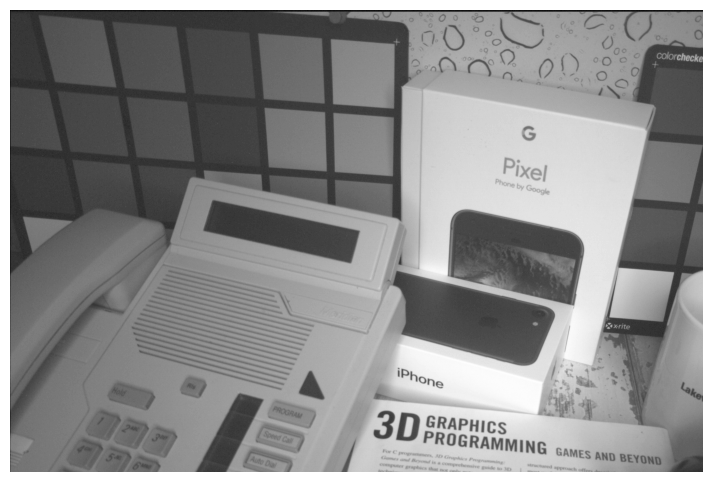

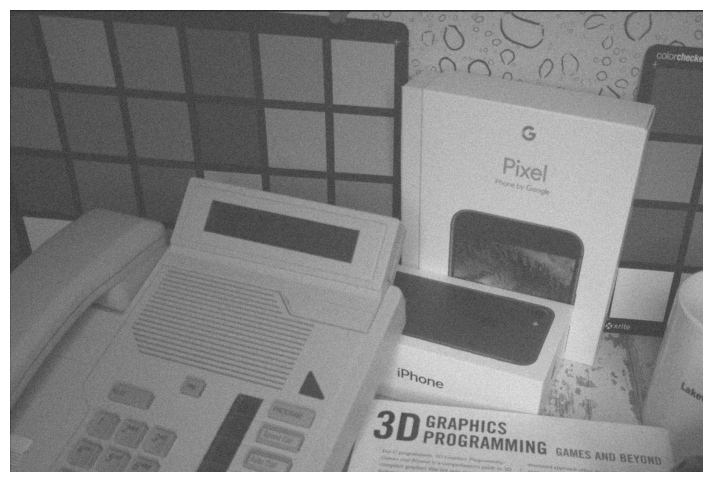

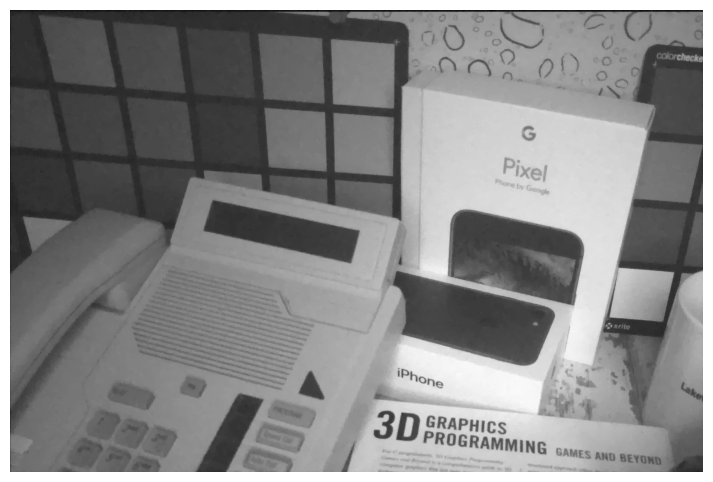

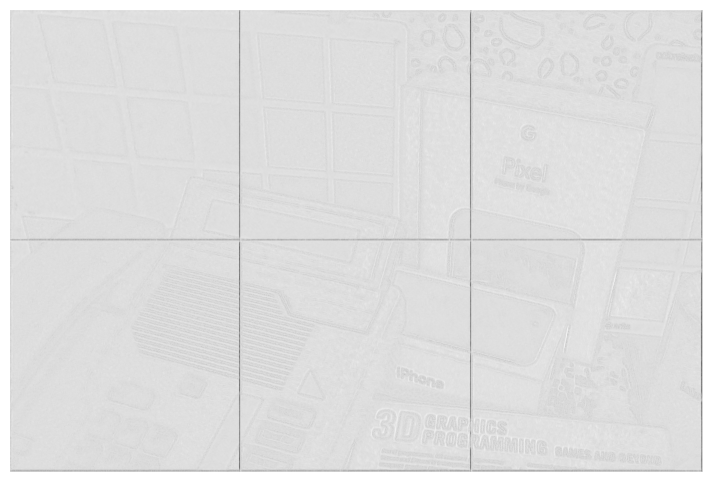

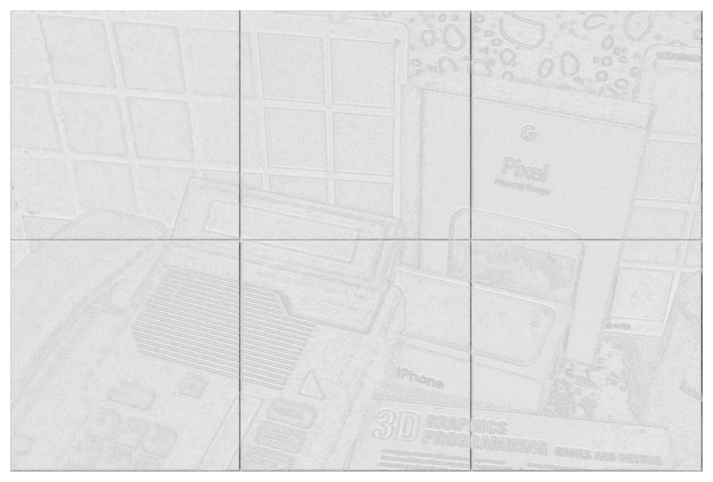

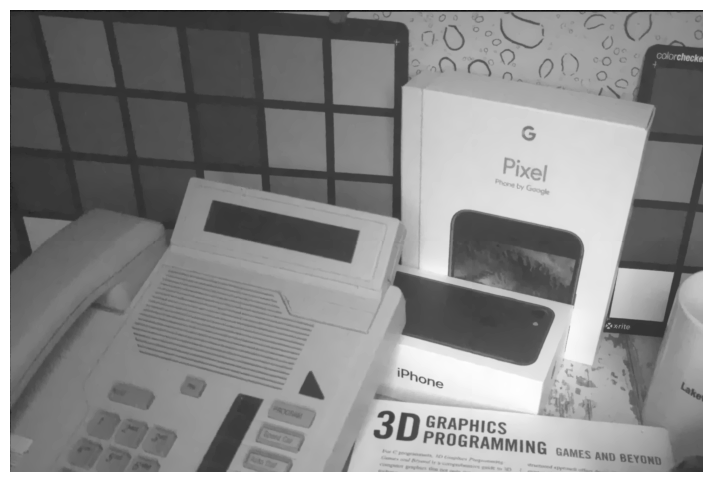

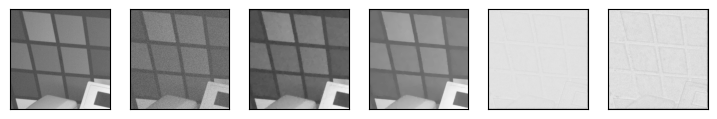

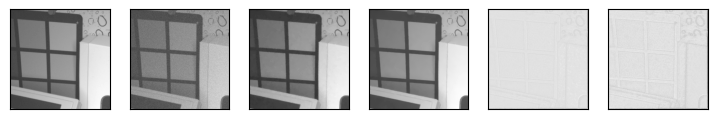

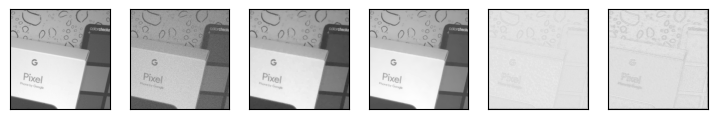

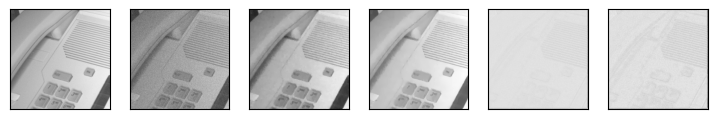

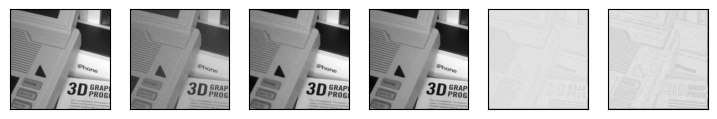

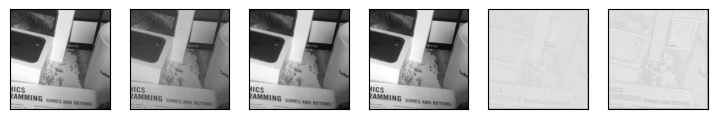

In [90]:
# CODE TO INFER AND SHOW SOME RESULTS HERE


# Use pdhg for prediction
def test_denoise(model_name, model_folder, trained_on):
    """
    Testing denoising with pre-trained parameters. We can 
    try any image we want. If the image is larger than 192x192, 
    we have to crop it to 192x192 patches and then stitch the
    patches back together.

    TODO: If the size is not divisible by 192, we have to pad
    the image with zeros to make it divisible by 192. Then we
    remove the padding before/after stitching the patches back
    together.
    """
    with torch.no_grad(): # IMPORTANT! Need no_grad to free GPU cache
        torch.cuda.empty_cache()

        # Get a clean image
        img_id = "0065"  # scene 003
        # img_id = "0102"
        # img_id = "0044"  # scene 002
        # img_id = "0055"
        # img_id = "0030"
        # scale = 0.25
        scale = 0.5
        clean_image = load_images([img_id], False)[0]
        clean_image = convert_to_grayscale(clean_image)
        clean_image = resize_image(clean_image, scale)
        clean_image = convert_to_tensor(clean_image)

        # k_w, k_h = 192, 192
        k_w, k_h = 512, 512
        kernel_size = [k_w, k_h, 1]
        stride = [k_w, k_h, 1]
        img_h = clean_image.size(1)
        img_w = clean_image.size(2)
        n_rows = img_h // k_h
        n_cols = img_w // k_w
        # best_lambda = 0.03 # Found by brute force on image 0065 kernel 192x192, sigma 0.3
        best_lambda = 0.05 # Found by brute force on image 0065 kernel 512x512, sigma 0.3
        # best_lambda = 0.2 # Found by brute force on image 0065 kernel 512x512, sigma 1
        sigma = 0.3
        # sigma = 1
        # activation = "ReLU"
        activation = "LeakyReLU"

        folder_name = f"./tmp/images/presentation-img_{img_id}-scale_{str(scale).replace('.', '_')}-sigma_{str(sigma).replace('.', '_')}-best_lambda_{str(best_lambda).replace('.', '_')}-kernel_{k_w}-model_{model_name}-activation_{activation}-trained_on_{trained_on}-time_{datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')}"
        

        os.makedirs(folder_name, exist_ok=True)

        with open(f"{folder_name}/logs.txt", "w") as log_file:
            print(f"Image ID: {img_id}", file=log_file)
            print(f"Scale: {scale}", file=log_file)
            print(f"Kernel size: {kernel_size}", file=log_file)
            print(f"Stride: {stride}", file=log_file)
            print(f"Best lambda: {best_lambda}", file=log_file)
            print(f"Sigma: {sigma}", file=log_file)
            print(f"Model name: {model_name}", file=log_file)
            # print(f"Model folder: {model_folder}", file=log_file)
            print(f"(Need to verify) Trained on: {trained_on}", file=log_file)
            # print(f"Folder name: {folder_name}", file=log_file)


            # Crop image to size divisible by kernel size
            clean_image = clean_image[:, :kernel_size[0]*n_rows, :kernel_size[0]*n_cols]
            x_patches_clean = extract_patches_3d(
                clean_image, 
                kernel_size=kernel_size, padding=0, stride=stride, dilation=1)
            save_image_and_patches(
                clean_image, x_patches_clean, "clean", 
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray', 
                # showing=True
                )

            # Add noise to the image
            noisy_image = add_noise(clean_image, sigma=sigma)
            x_patches = extract_patches_3d(
                noisy_image, 
                kernel_size=kernel_size, padding=0, stride=stride, dilation=1)
            save_image_and_patches(
                noisy_image, x_patches, "noisy",
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray', 
                # showing=True
                )


            # Denoise the image using a single lambda
            # best_lambda = 0.1 # Purposefully using the wrong lambda to see the effect
            x_denoised_single_lambda = reconstruct_with_PDHG(noisy_image.unsqueeze(0), best_lambda, T=128)
            x_denoised_single_lambda = x_denoised_single_lambda.squeeze(0)
            x_denoised_single_lambda_patches = extract_patches_3d(
                x_denoised_single_lambda, 
                kernel_size=kernel_size, padding=0, stride=stride, dilation=1)
            save_image_and_patches(
                x_denoised_single_lambda, x_denoised_single_lambda_patches, "denoised_single_lambda", 
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
                )
        
            
            # Denoise the patches using our method
            torch.cuda.empty_cache()
            unet = UNet().to(DEVICE)
            total_params = sum(p.numel() for p in unet.parameters())
            print(f"UNet total parameters: {total_params}", file=log_file)
            # pdhg_state_dicts = torch.load(f"{model_folder}/{model_name}.pt")
            # pdhg = DynamicImageStaticPrimalDualNN(
            #     cnn_block=unet, 
            #     # T=128,
            #     T=1000,
            #     phase="training",
            #     up_bound=0.5,
            #     mode="lambda_cnn",
            # ).to(DEVICE)
            # pdhg.load_state_dict(pdhg_state_dicts)
            pdhg = torch.load(f"{model_folder}/{model_name}.pt")

            torch.save(pdhg.state_dict(), f"{model_folder}/{model_name}_state_dict.pt")

            pdhg.eval()
            final_lambda_reg_max = 0
            final_lambda_reg_min = 1
            x_patches_denoised = []
            lambda_reg_x_patches = []
            lambda_reg_y_patches = []
            for i in range(len(x_patches)):
                noisy_patch = x_patches[i]
                noisy_patch = noisy_patch.unsqueeze(0)
                denoised_patch = pdhg(noisy_patch)

                # Analyse lambda map
                lambda_reg_patch = pdhg.cnn(noisy_patch)
                print(f"lambda_reg_patch shape: {lambda_reg_patch.shape}")
                
                lambda_reg_x_patch = lambda_reg_patch[:, 0, :, :]
                lambda_reg_y_patch = lambda_reg_patch[:, 1, :, :]
                
                lambda_reg_x_patches.append(lambda_reg_x_patch)
                lambda_reg_y_patches.append(lambda_reg_y_patch)

                lambda_reg_max = torch.max(lambda_reg_patch)
                lambda_reg_min = torch.min(lambda_reg_patch)
                if lambda_reg_max > final_lambda_reg_max:
                    final_lambda_reg_max = lambda_reg_max
                if lambda_reg_min < final_lambda_reg_min:
                    final_lambda_reg_min = lambda_reg_min

                denoised_patch = denoised_patch.squeeze(0)
                x_patches_denoised.append(denoised_patch)

            print(f"final_lambda_reg_max: {final_lambda_reg_max}", file=log_file)
            print(f"final_lambda_reg_min: {final_lambda_reg_min}", file=log_file)

            x_patches_denoised = torch.stack(x_patches_denoised)

            torch.cuda.empty_cache()

            # Convert list to tensor
            lambda_reg_x_patches = torch.stack(lambda_reg_x_patches)
            lambda_reg_y_patches = torch.stack(lambda_reg_y_patches)

            image_denoised_lambda_map = stitch_patches_back_to_image(
                x_patches_denoised,
                img_h=clean_image.size(1),
                img_w=clean_image.size(2),
                k_h=k_h,
                k_w=k_w)
            
            # Clip to 0 and 1
            image_denoised_lambda_map = torch.clamp(image_denoised_lambda_map, 0, 1)

            lambda_reg_x_all = stitch_patches_back_to_image(
                lambda_reg_x_patches,
                img_h=img_h,
                img_w=img_w,
                k_h=k_h,
                k_w=k_w)
            lambda_reg_y_all = stitch_patches_back_to_image(
                lambda_reg_y_patches,
                img_h=img_h,
                img_w=img_w,
                k_h=k_h,
                k_w=k_w)
            save_image_and_patches(
                lambda_reg_x_all, lambda_reg_x_patches, "lambda_reg_x",
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
                )
            save_image_and_patches(
                lambda_reg_y_all, lambda_reg_y_patches, "lambda_reg_y",
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
            )
            
            save_image_and_patches(
                image_denoised_lambda_map, x_patches_denoised, "denoised_lambda_map", 
                clean_image, n_rows, n_cols, folder_name, log_file=log_file, cmap='gray',
                # showing=True
                )

            save_patches_side_by_side(
                x_patches_clean, x_patches, x_denoised_single_lambda_patches, x_patches_denoised, lambda_reg_x_patches, lambda_reg_y_patches,
                folder_name, log_file=log_file,
                # showing=True
                )

            torch.cuda.empty_cache()

# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states/2024_05_24_23_04_31.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states/2024_05_24_23_29_27.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/good states/192 by 192 by 1 - trained on image 65 only/2024_05_24_23_29_27.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states - trained on all 200 images kernel size 192/2024_05_25_19_36_13.pt"))
# test_denoise(pdhg_state_dicts = torch.load(f"./tmp/states - trained on all 200 images kernel size 192/2024_05_25_19_36_13.pt"))
test_denoise(
    # model_name="img_0065-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_09_38_07_epoch_9774",
    model_name="img_0065-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_09_54_19_epoch_9962",
    # model_name="img_0065-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_07_10_36_epoch_8000",
    # model_name="model_epoch_408",
    # model_name="model_epoch_138",
    # model_name="model_epoch_1562",
    model_folder=f"./tmp/states",
    # model_folder=f"./tmp/model_scene_03-img_0054_to_0074-scale_0_5-kernel_512-sigma_0_3-T_128_2024_05_26_12_55_44",
    # model_folder=f"./tmp/model_img_0065-scale_0_5-kernel_512-sigma_0_3-T_128-ReLU_2024_05_26_15_11_22",
    # model_folder=f"./tmp/model_img_0065-scale_0_5-kernel_512-sigma_1-T_128-LeakyReLU_2024_05_26_15_55_13",
    trained_on="img_0065")


loading image id 0044, 1/1


 10%|█         | 1/10 [00:00<00:07,  1.23it/s]

single_lambda: 0.01, PSNR: 26.593799591064453


 20%|██        | 2/10 [00:01<00:07,  1.08it/s]

single_lambda: 0.022222222222222223, PSNR: 30.226062774658203


 30%|███       | 3/10 [00:02<00:06,  1.12it/s]

single_lambda: 0.034444444444444444, PSNR: 32.583866119384766


 40%|████      | 4/10 [00:03<00:05,  1.12it/s]

single_lambda: 0.04666666666666667, PSNR: 33.02165985107422


 50%|█████     | 5/10 [00:04<00:04,  1.08it/s]

single_lambda: 0.05888888888888889, PSNR: 32.591636657714844


 60%|██████    | 6/10 [00:05<00:03,  1.12it/s]

single_lambda: 0.07111111111111111, PSNR: 32.03215026855469


 70%|███████   | 7/10 [00:06<00:02,  1.07it/s]

single_lambda: 0.08333333333333333, PSNR: 31.521202087402344


 80%|████████  | 8/10 [00:07<00:01,  1.09it/s]

single_lambda: 0.09555555555555556, PSNR: 31.07876205444336


 90%|█████████ | 9/10 [00:08<00:00,  1.09it/s]

single_lambda: 0.10777777777777778, PSNR: 30.70348358154297


100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

single_lambda: 0.12, PSNR: 30.379507064819336
Best PSNR: 33.02165985107422 dB
Best lambda: 0.04666666666666667


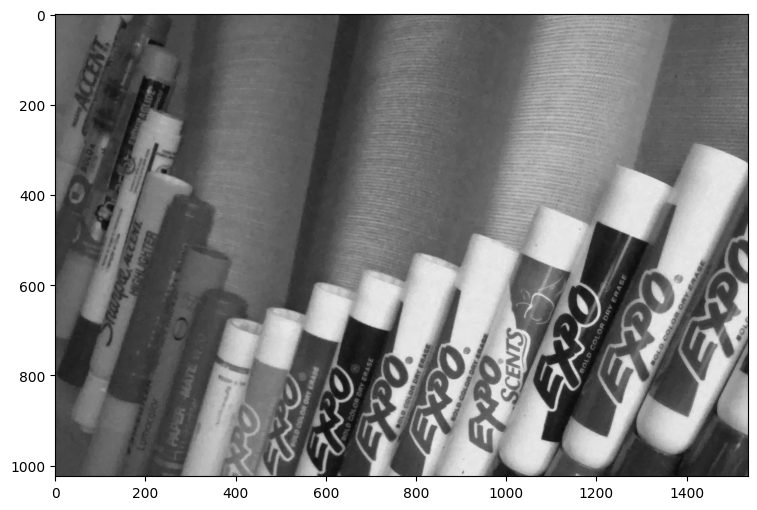

In [92]:
def brute_force_single_lambda():
    """
    To compare this with our method
    """

    # Try 
    with torch.no_grad(): # IMPORTANT! Need no_grad to free GPU cache
        torch.cuda.empty_cache()

        # Get a clean image
        # img_id = "0065"
        img_id = "0044"
        # img_id = "0102"
        # img_id = "0055"
        # img_id = "0030"
        # scale = 0.25
        scale = 0.5
        clean_image = load_images([img_id], False)[0]
        clean_image = convert_to_grayscale(clean_image)
        clean_image = resize_image(clean_image, scale)
        clean_image = convert_to_tensor(clean_image)

        # k_w, k_h = 192, 192
        k_w, k_h = 512, 512
        kernel_size = [k_w, k_h, 1]
        stride = [k_w, k_h, 1]
        img_h = clean_image.size(1)
        img_w = clean_image.size(2)
        n_rows = img_h // k_h
        n_cols = img_w // k_w
        sigma = 0.3
        # 0065: 0.05
        # 0044: 0.05
        # 0102: 0.02
        # sigma = 1

        # Crop image to size divisible by kernel size
        clean_image = clean_image[:, :kernel_size[0]*n_rows, :kernel_size[0]*n_cols]

        # Add noise to the image
        noisy_image = add_noise(clean_image, sigma=sigma)

        best_psnr = 0
        best_lambda = -100
        min_lambda = 0.01
        max_lambda = 0.12
        for single_lambda in tqdm(np.linspace(min_lambda, max_lambda, 10)):

            x_denoised = reconstruct_with_PDHG(noisy_image.unsqueeze(0), single_lambda, T=128)
            # print(f"x_denoised size: {x_denoised.size()}")

            x_denoised_psnr = PSNR(clean_image, x_denoised)
            print(f"single_lambda: {single_lambda}, PSNR: {x_denoised_psnr}")
            if x_denoised_psnr > best_psnr:
                best_psnr = x_denoised_psnr
                best_lambda = single_lambda

        print(f"Best PSNR: {best_psnr} dB")
        print(f"Best lambda: {best_lambda}")

        x_denoised = reconstruct_with_PDHG(noisy_image.unsqueeze(0), best_lambda, T=128)
        fig, ax = plt.subplots(1, 1, figsize=(9,6))
        plt.imshow(x_denoised.squeeze(0).squeeze(0).to("cpu").detach().numpy(), cmap='gray')
        plt.show();
        torch.cuda.empty_cache()
    
    torch.cuda.empty_cache()

brute_force_single_lambda()


------

### Results

Even though the PSNR increases slightly, there are still a few problems:

- The smaller details like text on a book almost always get lost.
- The model only works on small patches so combining the patches create a very unnatural-looking image.

------

### Conclusion

------

### Todo

I noticed that some GPU memory (about 1 GB) is still occupied after all code was done running. When I restarted the kernel all GPU memory is then freed. Is there somewhere else I should try to force emptying GPU cache?